In [1]:
import os, sys
import numpy as np
from itertools import cycle
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
import torch, torch.nn as nn, torch.nn.functional as F

In [3]:
from torchvision import datasets, transforms, models
from torchvision.transforms import RandAugment
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [4]:
### IMPORTANTE ###
FLAG_LOCAL = False # Alterar para False no kaggle

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", DEVICE)
if DEVICE.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: Tesla P100-PCIE-16GB


In [6]:
if FLAG_LOCAL:
    DATA_ROOT = './data'
else:
    DATA_ROOT = './kaggle/working/data'

In [7]:
NUM_CLASSES = 10
SEED = 42
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_full = datasets.CIFAR10(DATA_ROOT, train=True,  download=True, transform=None)
test_set   = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform=test_transform)

targets = np.array(train_full.targets)

100%|██████████| 170M/170M [00:04<00:00, 36.7MB/s]


In [8]:
def stratified_per_class_indices(targets, labels_per_class, seed=SEED):
    rng = np.random.default_rng(seed)
    
    idxs = []
    for c in range(NUM_CLASSES):
        cand   = np.where(targets == c)[0]
        choose = rng.choice(cand, size=labels_per_class, replace=False)
        idxs.extend(choose.tolist())
    
    return sorted(idxs)

In [9]:
class LabeledCIFAR10(Dataset):
    def __init__(self, base, indices, transform):
        self.base = base
        self.indices = indices
        self.transform = transform
    
    def __len__(self): return len(self.indices)
    
    def __getitem__(self, i):
        idx = self.indices[i]
        x, y = self.base.data[idx], self.base.targets[idx]
        x = transforms.ToPILImage()(x)

        return self.transform(x), y

class UnlabeledFixMatchCIFAR10(Dataset):
    def __init__(self, base, indices, weak_t, strong_t):
        self.base     = base
        self.indices  = indices
        self.weak_t   = weak_t
        self.strong_t = strong_t
    
    def __len__(self): return len(self.indices)
    
    def __getitem__(self, i):
        idx = self.indices[i]
        x = transforms.ToPILImage()(self.base.data[idx])

        return self.weak_t(x), self.strong_t(x)

In [10]:
# 3) Escolha o cenário (ex.: 4 rótulos/classe)
labels_per_class = 1  # troque para 1, 25, 400 conforme o experimento

labeled_idx   = stratified_per_class_indices(targets, labels_per_class, seed=SEED)
unlabeled_idx = sorted(list( set(range(len(train_full))) - set(labeled_idx) ))

labeled_ds   = LabeledCIFAR10(train_full, labeled_idx, transform=weak_transform)    # supervisionado
unlabeled_ds = UnlabeledFixMatchCIFAR10(train_full, unlabeled_idx, weak_t=weak_transform, strong_t=strong_transform)

In [11]:
# 4) Loaders (1:7 é a razão sup:unsup típica)

n_labeled   = len(labeled_ds)
n_unlabeled = len(unlabeled_ds)

batch_unsup_cfg = 448
batch_unsup     = min(batch_unsup_cfg, n_unlabeled)  # garante ao menos 1 batch

batch_sup_cfg = 64  # seu alvo
batch_sup     = min(batch_sup_cfg, n_labeled)
drop_last_sup = (n_labeled >= batch_sup_cfg)

In [12]:
sup_loader = DataLoader(labeled_ds,   batch_size=batch_sup,  drop_last=drop_last_sup, num_workers=2, pin_memory=True, 
                        sampler=RandomSampler(labeled_ds, replacement=True, num_samples=batch_sup * 256))

unsup_loader = DataLoader(unlabeled_ds, batch_size=batch_unsup, shuffle=True,  drop_last=True, num_workers=2, pin_memory=True)

test_loader  = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# Sanity check
# xb_sup, yb_sup = next(iter(sup_loader))
# xu_w, xu_s     = next(iter(unsup_loader))
# print("Sup batch:", xb_sup.shape, yb_sup.shape)
# print("Unsup weak/strong:", xu_w.shape, xu_s.shape)

In [13]:
class FixMatchLoss(nn.Module):
    def __init__(self, tau=0.95, lambda_u=1.0):
        super().__init__()
        self.tau = tau 
        self.lambda_u = lambda_u
        self.ce = nn.CrossEntropyLoss()
    
    @torch.no_grad()
    def pseudo(self, logits_weak):
        p = torch.softmax(logits_weak, dim=1)
        conf, yhat = p.max(dim=1)
        mask = (conf >= self.tau).float()
        return yhat, mask
    
    def forward(self, logits_sup, y_sup, logits_w, logits_s):
        Ls = self.ce(logits_sup, y_sup)
        yhat, mask = self.pseudo(logits_w)
        Lu_all = F.cross_entropy(logits_s, yhat, reduction='none')
        Lu = (Lu_all * mask).sum() / (mask.sum().clamp_min(1.0))
        return Ls + self.lambda_u*Lu, (Ls.item(), Lu.item(), mask.mean().item())

In [14]:
def build_model(num_classes=10):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    ce = nn.CrossEntropyLoss(reduction='sum')
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss_sum += ce(logits, yb).item()
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return {
        "acc": 100.0 * correct / total,
        "loss": loss_sum / total
    }

@torch.no_grad()
def evaluate_ema(model, ema_state, test_loader):
    """Avalia o modelo suavizado pela EMA."""
    backup = {k: v.clone() for k, v in model.state_dict().items()}
    model.load_state_dict(ema_state, strict=False)
    result = evaluate(model, test_loader)
    model.load_state_dict(backup)
    return result

In [15]:
def train_one_epoch_fixmatch(model, sup_loader, unsup_loader, optimizer, fm_loss, use_amp=True, ema_state=None, ema_decay=0.999):
    """
    Treina 1 época usando:
      - batches supervisionados de sup_loader
      - batches não rotulados 'em paralelo' vindos de unsup_loader (ciclando se necessário)
    Retorna médias de: loss total, Ls, Lu, mask_mean
    Atualiza também o modelo EMA (Exponential Moving Average), se fornecido.
    """
    model.train()
    scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and DEVICE.type == 'cuda'))

    L_all, Ls_all, Lu_all, m_all = [], [], [], []
    unsup_iter = cycle(unsup_loader)   # cicla para nunca faltar não-rotulado

    for xb, yb in sup_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        xu_w, xu_s = next(unsup_iter)
        xu_w, xu_s = xu_w.to(DEVICE), xu_s.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        if scaler.is_enabled():
            with torch.amp.autocast('cuda'):
                logits_sup    = model(xb)
                logits_weak   = model(xu_w)
                logits_strong = model(xu_s)
                loss, parts   = fm_loss(logits_sup, yb, logits_weak, logits_strong)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits_sup    = model(xb)
            logits_weak   = model(xu_w)
            logits_strong = model(xu_s)
            loss, parts   = fm_loss(logits_sup, yb, logits_weak, logits_strong)
            loss.backward()
            optimizer.step()

        if ema_state is not None:
            with torch.no_grad():
                for k, v in model.state_dict().items():
                    if k in ema_state:
                        if torch.is_floating_point(v):  # só atualiza tensores float
                            ema_state[k].mul_(ema_decay).add_(v.detach(), alpha=1 - ema_decay)
                        else:
                            ema_state[k] = v.clone()

        L_all.append(loss.item())
        Ls_all.append(parts[0] if isinstance(parts, (list, tuple)) else parts['Ls'])
        Lu_all.append(parts[1] if isinstance(parts, (list, tuple)) else parts['Lu'])
        m_all .append(parts[2] if isinstance(parts, (list, tuple)) else parts['mask_mean'])

    return {
        "loss": float(np.mean(L_all)),
        "Ls":   float(np.mean(Ls_all)),
        "Lu":   float(np.mean(Lu_all)),
        "mask": float(np.mean(m_all)),
    }

In [16]:
# Parâmetros
EPOCHS   = 1
LR       = 0.03
MOM      = 0.9
WD       = 5e-4
TAU      = 0.95
LAMBDA_U = 1.0
EMA_DECAY = 0.999  # decaimento da média móvel exponencial

In [17]:
# Instancia modelo, otimizador e a sua classe FixMatchLoss
model   = build_model(num_classes=10)

# Separa parâmetros: com e sem weight decay
no_decay = ['bias', 'bn'] # 'bn' cobre LayerNorm e BatchNorm
params_wd = []
params_no_wd = []

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    
    if any(nd in name.lower() for nd in no_decay):
        params_no_wd.append(param)
    else:
        params_wd.append(param)

# Agrupa os parâmetros para o otimizador
param_groups = [
    {'params': params_wd, 'weight_decay': WD},
    {'params': params_no_wd, 'weight_decay': 0.0} # Desliga o WD para este grupo
]

optim = torch.optim.SGD(param_groups, lr=LR, momentum=MOM, nesterov=True)

In [18]:
fm_loss = FixMatchLoss(tau=TAU, lambda_u=LAMBDA_U)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS, eta_min=0.0)

ema_state = {k: v.clone().detach() for k, v in model.state_dict().items()}

In [19]:
history    = {"train_loss":[], "train_Ls":[], "train_Lu":[], "train_mask":[], "test_acc":[], "test_loss":[]}
best       = {"acc": 0.0, "model_state": None, "epoch": 0}
train_model = {'model_state': None, 'optim_state': None, 'scheduler_state': None, 'ema_state': None, 'epoch': 0}

checkpoint = {'best': best, 'history': history, 'train_model' : train_model}

checkpoint_name = f"checkpoint_sup{labels_per_class}_tau{TAU}.pth"
checkpoint_path = os.path.join(DATA_ROOT, checkpoint_name)

if os.path.exists(checkpoint_path): # se já foi treinado antes, carrega o ultimo checkpoint
    print(f"Carregando checkpoint {checkpoint_path}...")

    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    best = checkpoint['best']
    train_model = checkpoint['train_model']
    history = checkpoint['history']
    
    # Carrega modelo em treinamento
    model.load_state_dict(train_model['model_state'])
    optim.load_state_dict(train_model['optim_state'])
    scheduler.load_state_dict(train_model['scheduler_state'])
    ema_state = train_model['ema_state']

    print(f"Pesos carregados. Melhor acurácia prévia: {best['acc']:.2f}% na época {best['epoch']}.")
else:
    print("Treinando do zero")

Treinando do zero


In [20]:
# === Loop de treinamento ===
for ep in tqdm(range(train_model['epoch'] + 1, EPOCHS+1)):
    tr = train_one_epoch_fixmatch(
        model, sup_loader, unsup_loader,
        optim, fm_loss, use_amp=True,
        ema_state=ema_state, ema_decay=EMA_DECAY
    )

    # Avalia o modelo suavizado (EMA)
    ev = evaluate_ema(model, ema_state, test_loader)

    scheduler.step()

    # Histórico
    history["train_loss"].append(tr["loss"])
    history["train_Ls"].append(tr["Ls"])
    history["train_Lu"].append(tr["Lu"])
    history["train_mask"].append(tr["mask"])
    history["test_acc"].append(ev["acc"])
    history["test_loss"].append(ev["loss"])

    # Melhor modelo
    if ev["acc"] > best["acc"]:
        best = {"acc": ev["acc"], "model_state": {k: v.clone() for k, v in ema_state.items()}, "epoch": ep}
        checkpoint['best'] = best
        checkpoint['history'] = history
        train_model = {
            'model_state': model.state_dict(),
            'optim_state': optim.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'ema_state': ema_state,
            'epoch': ep
        }
        checkpoint['train_model'] = train_model

        print(f"--> Salvando melhor modelo - Acc={best['acc']:.2f}% @ epoch {best['epoch']}")
        torch.save(checkpoint, checkpoint_path)
    elif ep % 5 == 0 or ep == EPOCHS:
        checkpoint['history'] = history
        train_model = {
            'model_state': model.state_dict(),
            'optim_state': optim.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'ema_state': ema_state,
            'epoch': ep
        }
        checkpoint['train_model'] = train_model

        print(f"--> Salvando checkpoint de treinamento @ epoch {ep}")
        torch.save(checkpoint, checkpoint_path)
    
    print(f"Ep {ep:03d} | L={tr['loss']:.3f} (Ls={tr['Ls']:.3f}, Lu={tr['Lu']:.3f}, m={tr['mask']:.2f}) "
          f"| Test Acc ={ev['acc']:.2f}%")

# === Carrega o melhor modelo e reavalia ===
if best["model_state"] is not None:
    model.load_state_dict(best["model_state"], strict=False)
final_ev = evaluate(model, test_loader)
print(f"Melhor acc: {best['acc']:.2f}% @ epoch {best['epoch']} | Final acc: {final_ev['acc']:.2f}%")

  0%|          | 0/1 [00:00<?, ?it/s]

--> Salvando melhor modelo - Acc=10.01% @ epoch 1


100%|██████████| 1/1 [00:50<00:00, 50.64s/it]

Ep 001 | L=3.165 (Ls=2.263, Lu=0.902, m=0.13) | Test Acc =10.01%


Melhor acc: 10.01% @ epoch 1 | Final acc: 10.01%


In [21]:
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        p = model(xb.to(DEVICE)).argmax(1).cpu().tolist()
        preds.extend(p)

print("Histograma de classes previstas no teste:", Counter(preds))

Histograma de classes previstas no teste: Counter({0: 9976, 7: 19, 5: 5})


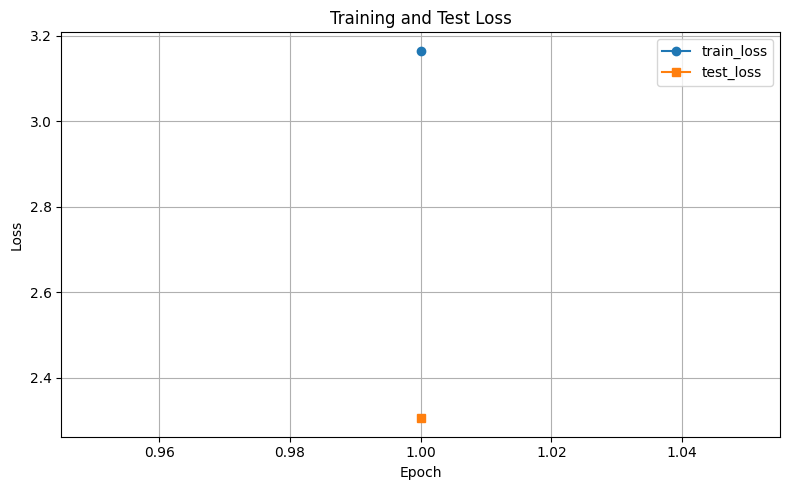

In [22]:
def plot_loss(history):
    if len(history["train_loss"]) == 0:
        print("Nenhum histórico disponível para plotar.")
    else:
        epochs = list(range(1, len(history["train_loss"]) + 1))
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, history["train_loss"], label="train_loss", marker='o')
        plt.plot(epochs, history["test_loss"],  label="test_loss",  marker='s')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Test Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
plot_loss(history)

In [23]:
def create_and_train_model(labels_per_class=1, epochs = 2, lr = 0.03, mom = 0.9, wd = 5e-4, tau = 0.95, lambda_u = 1.0, ema_decay = 0.999):
    # Datasets
    labeled_idx   = stratified_per_class_indices(targets, labels_per_class, seed=SEED)
    unlabeled_idx = sorted(list( set(range(len(train_full))) - set(labeled_idx) ))

    labeled_ds   = LabeledCIFAR10(train_full, labeled_idx, transform=weak_transform)    # supervisionado
    unlabeled_ds = UnlabeledFixMatchCIFAR10(train_full, unlabeled_idx, weak_t=weak_transform, strong_t=strong_transform)

    # Loaders
    n_labeled   = len(labeled_ds)
    n_unlabeled = len(unlabeled_ds)

    batch_unsup_cfg = 448
    batch_unsup     = min(batch_unsup_cfg, n_unlabeled)  # garante ao menos 1 batch

    batch_sup_cfg = 64  # seu alvo
    batch_sup     = min(batch_sup_cfg, n_labeled)
    drop_last_sup = (n_labeled >= batch_sup_cfg)

    sup_loader = DataLoader(labeled_ds,   batch_size=batch_sup,  drop_last=drop_last_sup, num_workers=2, pin_memory=True, 
                            sampler=RandomSampler(labeled_ds, replacement=True, num_samples=batch_sup * 256))
    unsup_loader = DataLoader(unlabeled_ds, batch_size=batch_unsup, shuffle=True,  drop_last=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    # Instancia modelo, otimizador e a sua classe FixMatchLoss
    model = build_model(num_classes=10)

    # Separa parâmetros: com e sem weight decay
    no_decay = ['bias', 'bn'] # 'bn' cobre LayerNorm e BatchNorm
    params_wd = []
    params_no_wd = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        if any(nd in name.lower() for nd in no_decay):
            params_no_wd.append(param)
        else:
            params_wd.append(param)

    # Agrupa os parâmetros para o otimizador
    param_groups = [
        {'params': params_wd, 'weight_decay': wd},
        {'params': params_no_wd, 'weight_decay': 0.0} # Desliga o WD para este grupo
    ]

    optim = torch.optim.SGD(param_groups, lr=lr, momentum=mom, nesterov=True)

    fm_loss = FixMatchLoss(tau=tau, lambda_u=lambda_u)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs, eta_min=0.0)

    ema_state = {k: v.clone().detach() for k, v in model.state_dict().items()}

    # cria estados iniciais para salvar o progresso
    history    = {"train_loss":[], "train_Ls":[], "train_Lu":[], "train_mask":[], "test_acc":[], "test_loss":[]}
    best       = {"acc": 0.0, "model_state": None, "epoch": 0}
    train_model = {'model_state': None, 'optim_state': None, 'scheduler_state': None, 'ema_state': None, 'epoch': 0}

    checkpoint = {'best': best, 'history': history, 'train_model' : train_model}

    checkpoint_name = f"checkpoint_sup{labels_per_class}_tau{round(100*tau)}.pth"
    checkpoint_path = os.path.join(DATA_ROOT, checkpoint_name)

    if os.path.exists(checkpoint_path): # se já foi treinado antes, carrega o ultimo checkpoint
        print(f"Carregando checkpoint {checkpoint_path}...")

        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        best = checkpoint['best']
        train_model = checkpoint['train_model']
        history = checkpoint['history']
        
        # Carrega modelo em treinamento
        model.load_state_dict(train_model['model_state'])
        optim.load_state_dict(train_model['optim_state'])
        scheduler.load_state_dict(train_model['scheduler_state'])
        ema_state = train_model['ema_state']

        print(f"Pesos carregados. Melhor acurácia prévia: {best['acc']:.2f}% na época {best['epoch']}.")
    else:
        print("Treinando do zero")    

    
    # === Loop de treinamento ===
    for ep in tqdm(range(train_model['epoch'] + 1, epochs+1)):
        tr = train_one_epoch_fixmatch(
            model, sup_loader, unsup_loader,
            optim, fm_loss, use_amp=True,
            ema_state=ema_state, ema_decay=ema_decay
        )

        # Avalia o modelo suavizado (EMA)
        ev = evaluate_ema(model, ema_state, test_loader)

        scheduler.step()

        # Histórico
        history["train_loss"].append(tr["loss"])
        history["train_Ls"].append(tr["Ls"])
        history["train_Lu"].append(tr["Lu"])
        history["train_mask"].append(tr["mask"])
        history["test_acc"].append(ev["acc"])
        history["test_loss"].append(ev["loss"])

        # Melhor modelo
        if ev["acc"] > best["acc"]:
            best = {"acc": ev["acc"], "model_state": {k: v.clone() for k, v in ema_state.items()}, "epoch": ep}
            checkpoint['best'] = best
            checkpoint['history'] = history
            train_model = {
                'model_state': model.state_dict(),
                'optim_state': optim.state_dict(),
                'scheduler_state': scheduler.state_dict(),
                'ema_state': ema_state,
                'epoch': ep
            }
            checkpoint['train_model'] = train_model

            print(f"  Salvando melhor modelo - Acc={best['acc']:.2f}% @ epoch {best['epoch']}")
            torch.save(checkpoint, checkpoint_path)
        elif ep % 5 == 0:
            checkpoint['history'] = history
            train_model = {
                'model_state': model.state_dict(),
                'optim_state': optim.state_dict(),
                'scheduler_state': scheduler.state_dict(),
                'ema_state': ema_state,
                'epoch': ep
            }
            checkpoint['train_model'] = train_model

            print(f"  Salvando checkpoint de treinamento @ epoch {ep}")
            torch.save(checkpoint, checkpoint_path)
        
        print(f"Ep {ep:03d} | L={tr['loss']:.3f} (Ls={tr['Ls']:.3f}, Lu={tr['Lu']:.3f}, m={tr['mask']:.2f}) "
            f"| Test Acc ={ev['acc']:.2f}%")

        # === Carrega o melhor modelo e reavalia no conjunto de teste ===
        if best["model_state"] is not None:
            model.load_state_dict(best["model_state"], strict=False)
        final_ev = evaluate(model, test_loader)
        print(f"Melhor acc: {best['acc']:.2f}% @ epoch {best['epoch']} | Final acc: {final_ev['acc']:.2f}%")

    plot_loss(history)

Treinando do zero


  0%|          | 0/2 [00:00<?, ?it/s]

  Salvando melhor modelo - Acc=10.00% @ epoch 1
Ep 001 | L=2.519 (Ls=1.544, Lu=0.975, m=0.21) | Test Acc =10.00%


 50%|█████     | 1/2 [00:52<00:52, 52.08s/it]

Melhor acc: 10.00% @ epoch 1 | Final acc: 10.00%
  Salvando melhor modelo - Acc=15.43% @ epoch 2
Ep 002 | L=1.280 (Ls=0.484, Lu=0.797, m=0.23) | Test Acc =15.43%


100%|██████████| 2/2 [01:45<00:00, 52.82s/it]

Melhor acc: 15.43% @ epoch 2 | Final acc: 15.43%


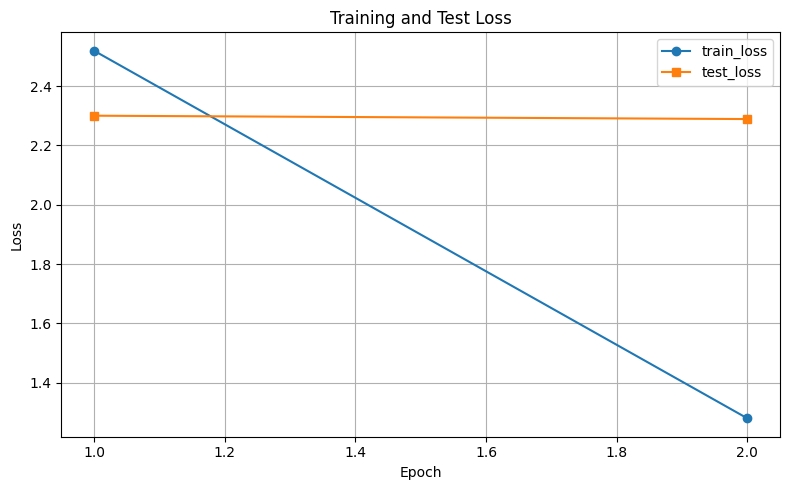

In [24]:
create_and_train_model()

Carregando checkpoint ./kaggle/working/data/checkpoint_sup1_tau95.pth...
Pesos carregados. Melhor acurácia prévia: 15.43% na época 2.


0it [00:00, ?it/s]


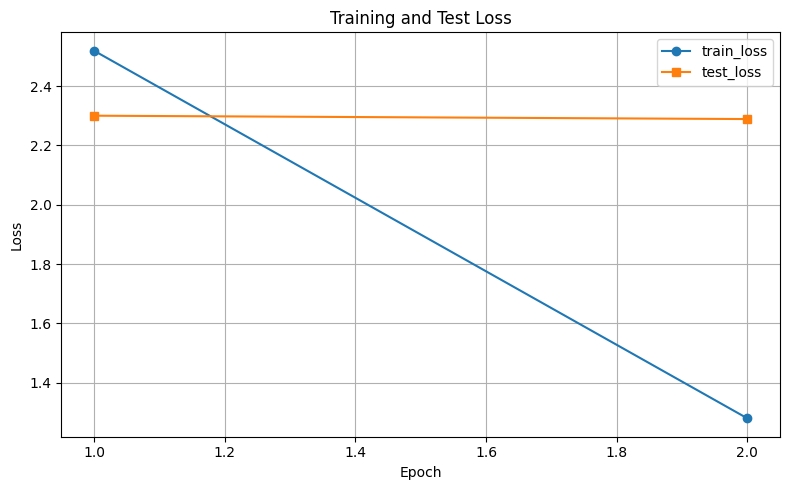

In [25]:
create_and_train_model() # checando



#### Treinando com 1 rótulos por classe e Tau=0.9 ####

Treinando do zero


  0%|          | 0/30 [00:00<?, ?it/s]

  Salvando melhor modelo - Acc=13.50% @ epoch 1
Ep 001 | L=3.563 (Ls=2.290, Lu=1.273, m=0.22) | Test Acc =13.50%


  3%|▎         | 1/30 [00:52<25:31, 52.81s/it]

Melhor acc: 13.50% @ epoch 1 | Final acc: 13.50%
Ep 002 | L=2.302 (Ls=1.503, Lu=0.799, m=0.25) | Test Acc =10.56%


  7%|▋         | 2/30 [01:44<24:18, 52.08s/it]

Melhor acc: 13.50% @ epoch 1 | Final acc: 13.50%
  Salvando melhor modelo - Acc=13.87% @ epoch 3
Ep 003 | L=2.481 (Ls=1.389, Lu=1.092, m=0.24) | Test Acc =13.87%


 10%|█         | 3/30 [02:36<23:21, 51.90s/it]

Melhor acc: 13.87% @ epoch 3 | Final acc: 13.87%
  Salvando melhor modelo - Acc=14.88% @ epoch 4
Ep 004 | L=1.728 (Ls=0.837, Lu=0.892, m=0.28) | Test Acc =14.88%


 13%|█▎        | 4/30 [03:26<22:09, 51.13s/it]

Melhor acc: 14.88% @ epoch 4 | Final acc: 14.88%
  Salvando melhor modelo - Acc=15.03% @ epoch 5
Ep 005 | L=1.873 (Ls=0.862, Lu=1.011, m=0.27) | Test Acc =15.03%


 17%|█▋        | 5/30 [04:17<21:19, 51.17s/it]

Melhor acc: 15.03% @ epoch 5 | Final acc: 15.03%
Ep 006 | L=1.434 (Ls=0.617, Lu=0.818, m=0.31) | Test Acc =14.56%


 20%|██        | 6/30 [05:08<20:28, 51.19s/it]

Melhor acc: 15.03% @ epoch 5 | Final acc: 15.03%
  Salvando melhor modelo - Acc=15.13% @ epoch 7
Ep 007 | L=1.546 (Ls=0.690, Lu=0.856, m=0.28) | Test Acc =15.13%


 23%|██▎       | 7/30 [06:00<19:40, 51.34s/it]

Melhor acc: 15.13% @ epoch 7 | Final acc: 15.13%
  Salvando melhor modelo - Acc=15.25% @ epoch 8
Ep 008 | L=0.878 (Ls=0.482, Lu=0.396, m=0.56) | Test Acc =15.25%


 27%|██▋       | 8/30 [06:51<18:52, 51.48s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 009 | L=0.465 (Ls=0.289, Lu=0.176, m=0.76) | Test Acc =13.53%


 30%|███       | 9/30 [07:43<17:59, 51.38s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
  Salvando checkpoint de treinamento @ epoch 10
Ep 010 | L=0.773 (Ls=0.494, Lu=0.279, m=0.64) | Test Acc =12.60%


 33%|███▎      | 10/30 [08:34<17:09, 51.49s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 011 | L=0.633 (Ls=0.350, Lu=0.283, m=0.63) | Test Acc =12.22%


 37%|███▋      | 11/30 [09:26<16:18, 51.52s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 012 | L=0.802 (Ls=0.316, Lu=0.486, m=0.48) | Test Acc =12.49%


 40%|████      | 12/30 [10:16<15:22, 51.23s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 013 | L=0.506 (Ls=0.265, Lu=0.241, m=0.70) | Test Acc =11.95%


 43%|████▎     | 13/30 [11:07<14:29, 51.15s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 014 | L=0.492 (Ls=0.230, Lu=0.262, m=0.71) | Test Acc =11.83%


 47%|████▋     | 14/30 [11:58<13:36, 51.02s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
  Salvando checkpoint de treinamento @ epoch 15
Ep 015 | L=0.506 (Ls=0.254, Lu=0.252, m=0.65) | Test Acc =12.38%


 50%|█████     | 15/30 [12:50<12:48, 51.21s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 016 | L=0.404 (Ls=0.232, Lu=0.172, m=0.74) | Test Acc =12.01%


 53%|█████▎    | 16/30 [13:41<11:55, 51.13s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 017 | L=0.262 (Ls=0.079, Lu=0.184, m=0.75) | Test Acc =12.14%


 57%|█████▋    | 17/30 [14:32<11:05, 51.21s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 018 | L=0.245 (Ls=0.100, Lu=0.145, m=0.76) | Test Acc =12.01%


 60%|██████    | 18/30 [15:23<10:13, 51.12s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 019 | L=0.192 (Ls=0.067, Lu=0.125, m=0.79) | Test Acc =12.03%


 63%|██████▎   | 19/30 [16:14<09:21, 51.05s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
  Salvando checkpoint de treinamento @ epoch 20
Ep 020 | L=0.134 (Ls=0.051, Lu=0.083, m=0.81) | Test Acc =11.97%


 67%|██████▋   | 20/30 [17:05<08:31, 51.10s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 021 | L=0.166 (Ls=0.060, Lu=0.106, m=0.78) | Test Acc =11.70%


 70%|███████   | 21/30 [17:56<07:39, 51.04s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 022 | L=0.233 (Ls=0.068, Lu=0.165, m=0.67) | Test Acc =11.82%


 73%|███████▎  | 22/30 [18:47<06:47, 50.96s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 023 | L=0.218 (Ls=0.062, Lu=0.156, m=0.65) | Test Acc =12.04%


 77%|███████▋  | 23/30 [19:38<05:56, 50.95s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 024 | L=0.235 (Ls=0.050, Lu=0.185, m=0.59) | Test Acc =12.37%


 80%|████████  | 24/30 [20:29<05:06, 51.06s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
  Salvando checkpoint de treinamento @ epoch 25
Ep 025 | L=0.297 (Ls=0.068, Lu=0.230, m=0.49) | Test Acc =12.67%


 83%|████████▎ | 25/30 [21:21<04:16, 51.30s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 026 | L=0.344 (Ls=0.077, Lu=0.267, m=0.41) | Test Acc =13.21%


 87%|████████▋ | 26/30 [22:12<03:25, 51.29s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 027 | L=0.404 (Ls=0.086, Lu=0.317, m=0.34) | Test Acc =13.61%


 90%|█████████ | 27/30 [23:04<02:34, 51.34s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 028 | L=0.450 (Ls=0.096, Lu=0.354, m=0.29) | Test Acc =13.93%


 93%|█████████▎| 28/30 [23:55<01:42, 51.32s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
Ep 029 | L=0.498 (Ls=0.097, Lu=0.401, m=0.24) | Test Acc =14.29%


 97%|█████████▋| 29/30 [24:46<00:51, 51.29s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%
  Salvando checkpoint de treinamento @ epoch 30
Ep 030 | L=0.581 (Ls=0.105, Lu=0.476, m=0.20) | Test Acc =14.62%


100%|██████████| 30/30 [25:38<00:00, 51.28s/it]

Melhor acc: 15.25% @ epoch 8 | Final acc: 15.25%


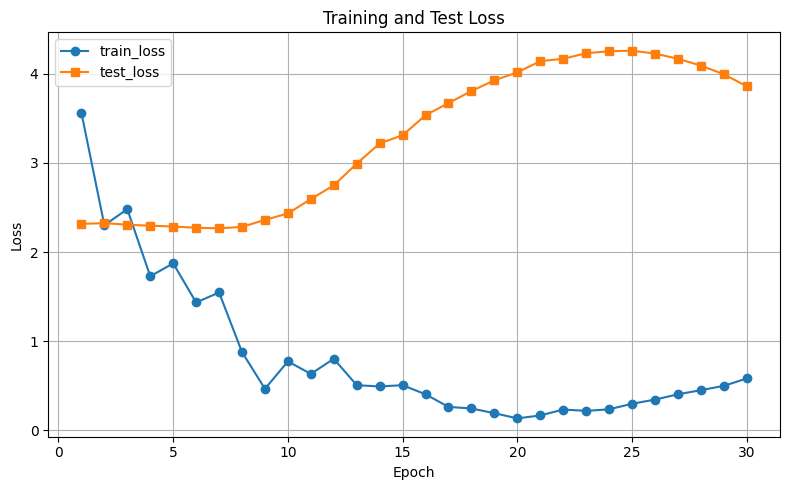



#### Treinando com 4 rótulos por classe e Tau=0.9 ####

Treinando do zero


  0%|          | 0/30 [00:00<?, ?it/s]

  Salvando melhor modelo - Acc=10.89% @ epoch 1
Ep 001 | L=1.588 (Ls=0.649, Lu=0.940, m=0.21) | Test Acc =10.89%


  3%|▎         | 1/30 [00:52<25:22, 52.52s/it]

Melhor acc: 10.89% @ epoch 1 | Final acc: 10.89%
  Salvando melhor modelo - Acc=16.56% @ epoch 2
Ep 002 | L=1.209 (Ls=0.344, Lu=0.865, m=0.32) | Test Acc =16.56%


  7%|▋         | 2/30 [01:45<24:31, 52.56s/it]

Melhor acc: 16.56% @ epoch 2 | Final acc: 16.56%
  Salvando melhor modelo - Acc=17.34% @ epoch 3
Ep 003 | L=0.805 (Ls=0.224, Lu=0.581, m=0.44) | Test Acc =17.34%


 10%|█         | 3/30 [02:37<23:38, 52.53s/it]

Melhor acc: 17.34% @ epoch 3 | Final acc: 17.34%
  Salvando melhor modelo - Acc=18.81% @ epoch 4
Ep 004 | L=0.752 (Ls=0.213, Lu=0.539, m=0.49) | Test Acc =18.81%


 13%|█▎        | 4/30 [03:30<22:46, 52.56s/it]

Melhor acc: 18.81% @ epoch 4 | Final acc: 18.81%
  Salvando melhor modelo - Acc=19.61% @ epoch 5
Ep 005 | L=0.702 (Ls=0.158, Lu=0.545, m=0.48) | Test Acc =19.61%


 17%|█▋        | 5/30 [04:22<21:51, 52.44s/it]

Melhor acc: 19.61% @ epoch 5 | Final acc: 19.61%
  Salvando melhor modelo - Acc=20.59% @ epoch 6
Ep 006 | L=0.713 (Ls=0.189, Lu=0.524, m=0.49) | Test Acc =20.59%


 20%|██        | 6/30 [05:15<21:01, 52.55s/it]

Melhor acc: 20.59% @ epoch 6 | Final acc: 20.59%
  Salvando melhor modelo - Acc=21.44% @ epoch 7
Ep 007 | L=0.542 (Ls=0.153, Lu=0.389, m=0.61) | Test Acc =21.44%


 23%|██▎       | 7/30 [06:07<20:09, 52.60s/it]

Melhor acc: 21.44% @ epoch 7 | Final acc: 21.44%
Ep 008 | L=0.217 (Ls=0.090, Lu=0.127, m=0.84) | Test Acc =21.09%


 27%|██▋       | 8/30 [07:00<19:14, 52.48s/it]

Melhor acc: 21.44% @ epoch 7 | Final acc: 21.44%
  Salvando melhor modelo - Acc=22.00% @ epoch 9
Ep 009 | L=0.088 (Ls=0.043, Lu=0.045, m=0.93) | Test Acc =22.00%


 30%|███       | 9/30 [07:52<18:23, 52.57s/it]

Melhor acc: 22.00% @ epoch 9 | Final acc: 22.00%
  Salvando melhor modelo - Acc=23.77% @ epoch 10
Ep 010 | L=0.276 (Ls=0.057, Lu=0.219, m=0.79) | Test Acc =23.77%


 33%|███▎      | 10/30 [08:46<17:35, 52.76s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 011 | L=0.099 (Ls=0.023, Lu=0.075, m=0.91) | Test Acc =22.97%


 37%|███▋      | 11/30 [09:38<16:43, 52.79s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 012 | L=0.068 (Ls=0.003, Lu=0.065, m=0.90) | Test Acc =21.73%


 40%|████      | 12/30 [10:31<15:50, 52.82s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 013 | L=0.176 (Ls=0.024, Lu=0.152, m=0.85) | Test Acc =20.50%


 43%|████▎     | 13/30 [11:23<14:53, 52.59s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 014 | L=0.055 (Ls=0.004, Lu=0.051, m=0.92) | Test Acc =18.98%


 47%|████▋     | 14/30 [12:16<13:59, 52.48s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
  Salvando checkpoint de treinamento @ epoch 15
Ep 015 | L=0.045 (Ls=0.005, Lu=0.040, m=0.94) | Test Acc =17.39%


 50%|█████     | 15/30 [13:08<13:08, 52.54s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 016 | L=0.122 (Ls=0.005, Lu=0.117, m=0.85) | Test Acc =16.56%


 53%|█████▎    | 16/30 [14:01<12:14, 52.48s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 017 | L=0.099 (Ls=0.003, Lu=0.095, m=0.86) | Test Acc =16.18%


 57%|█████▋    | 17/30 [14:52<11:19, 52.23s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 018 | L=0.085 (Ls=0.006, Lu=0.079, m=0.89) | Test Acc =15.78%


 60%|██████    | 18/30 [15:43<10:22, 51.85s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 019 | L=0.096 (Ls=0.002, Lu=0.094, m=0.87) | Test Acc =15.29%


 63%|██████▎   | 19/30 [16:38<09:38, 52.59s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
  Salvando checkpoint de treinamento @ epoch 20
Ep 020 | L=0.100 (Ls=0.004, Lu=0.096, m=0.86) | Test Acc =15.04%


 67%|██████▋   | 20/30 [17:31<08:49, 52.97s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 021 | L=0.095 (Ls=0.006, Lu=0.090, m=0.86) | Test Acc =14.97%


 70%|███████   | 21/30 [18:24<07:55, 52.86s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 022 | L=0.147 (Ls=0.004, Lu=0.144, m=0.78) | Test Acc =15.41%


 73%|███████▎  | 22/30 [19:17<07:02, 52.79s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 023 | L=0.188 (Ls=0.003, Lu=0.185, m=0.72) | Test Acc =16.64%


 77%|███████▋  | 23/30 [20:08<06:06, 52.38s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 024 | L=0.167 (Ls=0.004, Lu=0.163, m=0.74) | Test Acc =17.03%


 80%|████████  | 24/30 [20:59<05:12, 52.05s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
  Salvando checkpoint de treinamento @ epoch 25
Ep 025 | L=0.237 (Ls=0.002, Lu=0.235, m=0.64) | Test Acc =18.19%


 83%|████████▎ | 25/30 [21:51<04:19, 51.85s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 026 | L=0.293 (Ls=0.001, Lu=0.292, m=0.57) | Test Acc =19.51%


 87%|████████▋ | 26/30 [22:42<03:26, 51.55s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 027 | L=0.325 (Ls=0.002, Lu=0.323, m=0.52) | Test Acc =20.65%


 90%|█████████ | 27/30 [23:33<02:34, 51.58s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 028 | L=0.481 (Ls=0.001, Lu=0.480, m=0.37) | Test Acc =21.89%


 93%|█████████▎| 28/30 [24:24<01:42, 51.25s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
Ep 029 | L=0.550 (Ls=0.000, Lu=0.550, m=0.33) | Test Acc =22.90%


 97%|█████████▋| 29/30 [25:15<00:51, 51.22s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%
  Salvando checkpoint de treinamento @ epoch 30
Ep 030 | L=0.592 (Ls=0.000, Lu=0.592, m=0.31) | Test Acc =23.75%


100%|██████████| 30/30 [26:07<00:00, 52.24s/it]

Melhor acc: 23.77% @ epoch 10 | Final acc: 23.77%


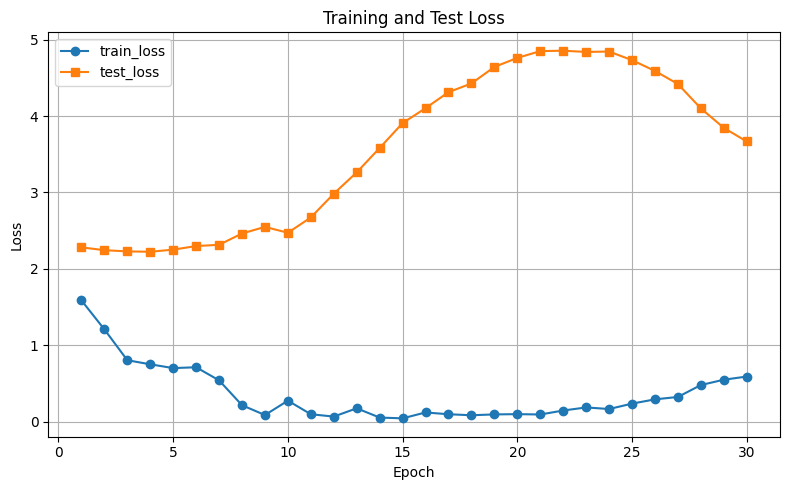



#### Treinando com 25 rótulos por classe e Tau=0.9 ####

Treinando do zero


  0%|          | 0/30 [00:00<?, ?it/s]

  Salvando melhor modelo - Acc=13.51% @ epoch 1
Ep 001 | L=2.629 (Ls=1.953, Lu=0.676, m=0.11) | Test Acc =13.51%


  3%|▎         | 1/30 [00:51<24:57, 51.64s/it]

Melhor acc: 13.51% @ epoch 1 | Final acc: 13.51%
  Salvando melhor modelo - Acc=14.12% @ epoch 2
Ep 002 | L=2.054 (Ls=1.313, Lu=0.741, m=0.16) | Test Acc =14.12%


  7%|▋         | 2/30 [01:43<24:10, 51.80s/it]

Melhor acc: 14.12% @ epoch 2 | Final acc: 14.12%
  Salvando melhor modelo - Acc=14.21% @ epoch 3
Ep 003 | L=2.153 (Ls=1.401, Lu=0.751, m=0.16) | Test Acc =14.21%


 10%|█         | 3/30 [02:35<23:22, 51.96s/it]

Melhor acc: 14.21% @ epoch 3 | Final acc: 14.21%
  Salvando melhor modelo - Acc=17.83% @ epoch 4
Ep 004 | L=1.579 (Ls=0.821, Lu=0.758, m=0.23) | Test Acc =17.83%


 13%|█▎        | 4/30 [03:27<22:29, 51.90s/it]

Melhor acc: 17.83% @ epoch 4 | Final acc: 17.83%
  Salvando melhor modelo - Acc=20.87% @ epoch 5
Ep 005 | L=1.310 (Ls=0.551, Lu=0.759, m=0.28) | Test Acc =20.87%


 17%|█▋        | 5/30 [04:18<21:32, 51.71s/it]

Melhor acc: 20.87% @ epoch 5 | Final acc: 20.87%
  Salvando melhor modelo - Acc=26.36% @ epoch 6
Ep 006 | L=1.201 (Ls=0.427, Lu=0.773, m=0.29) | Test Acc =26.36%


 20%|██        | 6/30 [05:10<20:41, 51.73s/it]

Melhor acc: 26.36% @ epoch 6 | Final acc: 26.36%
  Salvando melhor modelo - Acc=30.85% @ epoch 7
Ep 007 | L=1.086 (Ls=0.326, Lu=0.759, m=0.33) | Test Acc =30.85%


 23%|██▎       | 7/30 [06:02<19:48, 51.68s/it]

Melhor acc: 30.85% @ epoch 7 | Final acc: 30.85%
  Salvando melhor modelo - Acc=34.59% @ epoch 8
Ep 008 | L=1.001 (Ls=0.268, Lu=0.733, m=0.34) | Test Acc =34.59%


 27%|██▋       | 8/30 [06:53<18:56, 51.67s/it]

Melhor acc: 34.59% @ epoch 8 | Final acc: 34.59%
  Salvando melhor modelo - Acc=37.05% @ epoch 9
Ep 009 | L=0.944 (Ls=0.229, Lu=0.716, m=0.35) | Test Acc =37.05%


 30%|███       | 9/30 [07:45<18:05, 51.69s/it]

Melhor acc: 37.05% @ epoch 9 | Final acc: 37.05%
  Salvando melhor modelo - Acc=39.11% @ epoch 10
Ep 010 | L=0.867 (Ls=0.181, Lu=0.686, m=0.36) | Test Acc =39.11%


 33%|███▎      | 10/30 [08:38<17:19, 51.96s/it]

Melhor acc: 39.11% @ epoch 10 | Final acc: 39.11%
  Salvando melhor modelo - Acc=40.53% @ epoch 11
Ep 011 | L=0.815 (Ls=0.154, Lu=0.661, m=0.36) | Test Acc =40.53%


 37%|███▋      | 11/30 [09:30<16:27, 51.96s/it]

Melhor acc: 40.53% @ epoch 11 | Final acc: 40.53%
  Salvando melhor modelo - Acc=42.03% @ epoch 12
Ep 012 | L=0.783 (Ls=0.132, Lu=0.651, m=0.37) | Test Acc =42.03%


 40%|████      | 12/30 [10:22<15:35, 51.97s/it]

Melhor acc: 42.03% @ epoch 12 | Final acc: 42.03%
  Salvando melhor modelo - Acc=43.27% @ epoch 13
Ep 013 | L=0.737 (Ls=0.115, Lu=0.621, m=0.39) | Test Acc =43.27%


 43%|████▎     | 13/30 [11:14<14:46, 52.17s/it]

Melhor acc: 43.27% @ epoch 13 | Final acc: 43.27%
  Salvando melhor modelo - Acc=43.91% @ epoch 14
Ep 014 | L=0.689 (Ls=0.085, Lu=0.604, m=0.40) | Test Acc =43.91%


 47%|████▋     | 14/30 [12:07<13:55, 52.20s/it]

Melhor acc: 43.91% @ epoch 14 | Final acc: 43.91%
  Salvando melhor modelo - Acc=44.55% @ epoch 15
Ep 015 | L=0.655 (Ls=0.073, Lu=0.582, m=0.40) | Test Acc =44.55%


 50%|█████     | 15/30 [12:59<13:04, 52.28s/it]

Melhor acc: 44.55% @ epoch 15 | Final acc: 44.55%
  Salvando melhor modelo - Acc=44.96% @ epoch 16
Ep 016 | L=0.635 (Ls=0.055, Lu=0.579, m=0.42) | Test Acc =44.96%


 53%|█████▎    | 16/30 [13:51<12:12, 52.29s/it]

Melhor acc: 44.96% @ epoch 16 | Final acc: 44.96%
  Salvando melhor modelo - Acc=45.33% @ epoch 17
Ep 017 | L=0.593 (Ls=0.046, Lu=0.547, m=0.43) | Test Acc =45.33%


 57%|█████▋    | 17/30 [14:43<11:19, 52.23s/it]

Melhor acc: 45.33% @ epoch 17 | Final acc: 45.33%
  Salvando melhor modelo - Acc=45.67% @ epoch 18
Ep 018 | L=0.573 (Ls=0.029, Lu=0.544, m=0.45) | Test Acc =45.67%


 60%|██████    | 18/30 [15:37<10:30, 52.51s/it]

Melhor acc: 45.67% @ epoch 18 | Final acc: 45.67%
  Salvando melhor modelo - Acc=45.81% @ epoch 19
Ep 019 | L=0.544 (Ls=0.023, Lu=0.521, m=0.45) | Test Acc =45.81%


 63%|██████▎   | 19/30 [16:29<09:38, 52.64s/it]

Melhor acc: 45.81% @ epoch 19 | Final acc: 45.81%
  Salvando melhor modelo - Acc=45.94% @ epoch 20
Ep 020 | L=0.545 (Ls=0.024, Lu=0.521, m=0.46) | Test Acc =45.94%


 67%|██████▋   | 20/30 [17:22<08:46, 52.61s/it]

Melhor acc: 45.94% @ epoch 20 | Final acc: 45.94%
  Salvando melhor modelo - Acc=46.26% @ epoch 21
Ep 021 | L=0.528 (Ls=0.019, Lu=0.509, m=0.45) | Test Acc =46.26%


 70%|███████   | 21/30 [18:15<07:53, 52.57s/it]

Melhor acc: 46.26% @ epoch 21 | Final acc: 46.26%
  Salvando melhor modelo - Acc=46.35% @ epoch 22
Ep 022 | L=0.496 (Ls=0.009, Lu=0.487, m=0.47) | Test Acc =46.35%


 73%|███████▎  | 22/30 [19:07<07:00, 52.62s/it]

Melhor acc: 46.35% @ epoch 22 | Final acc: 46.35%
  Salvando melhor modelo - Acc=46.76% @ epoch 23
Ep 023 | L=0.513 (Ls=0.010, Lu=0.503, m=0.49) | Test Acc =46.76%


 77%|███████▋  | 23/30 [20:00<06:08, 52.58s/it]

Melhor acc: 46.76% @ epoch 23 | Final acc: 46.76%
  Salvando melhor modelo - Acc=46.93% @ epoch 24
Ep 024 | L=0.477 (Ls=0.004, Lu=0.472, m=0.49) | Test Acc =46.93%


 80%|████████  | 24/30 [20:52<05:14, 52.47s/it]

Melhor acc: 46.93% @ epoch 24 | Final acc: 46.93%
  Salvando melhor modelo - Acc=47.04% @ epoch 25
Ep 025 | L=0.490 (Ls=0.003, Lu=0.487, m=0.47) | Test Acc =47.04%


 83%|████████▎ | 25/30 [21:44<04:22, 52.42s/it]

Melhor acc: 47.04% @ epoch 25 | Final acc: 47.04%
  Salvando melhor modelo - Acc=47.08% @ epoch 26
Ep 026 | L=0.475 (Ls=0.002, Lu=0.474, m=0.48) | Test Acc =47.08%


 87%|████████▋ | 26/30 [22:37<03:29, 52.49s/it]

Melhor acc: 47.08% @ epoch 26 | Final acc: 47.08%
Ep 027 | L=0.483 (Ls=0.001, Lu=0.482, m=0.47) | Test Acc =46.91%


 90%|█████████ | 27/30 [23:29<02:37, 52.35s/it]

Melhor acc: 47.08% @ epoch 26 | Final acc: 47.08%
Ep 028 | L=0.483 (Ls=0.001, Lu=0.482, m=0.46) | Test Acc =47.04%


 93%|█████████▎| 28/30 [24:21<01:44, 52.34s/it]

Melhor acc: 47.08% @ epoch 26 | Final acc: 47.08%
Ep 029 | L=0.492 (Ls=0.001, Lu=0.492, m=0.46) | Test Acc =47.06%


 97%|█████████▋| 29/30 [25:14<00:52, 52.35s/it]

Melhor acc: 47.08% @ epoch 26 | Final acc: 47.08%
  Salvando checkpoint de treinamento @ epoch 30
Ep 030 | L=0.499 (Ls=0.001, Lu=0.499, m=0.46) | Test Acc =46.96%


100%|██████████| 30/30 [26:07<00:00, 52.23s/it]

Melhor acc: 47.08% @ epoch 26 | Final acc: 47.08%


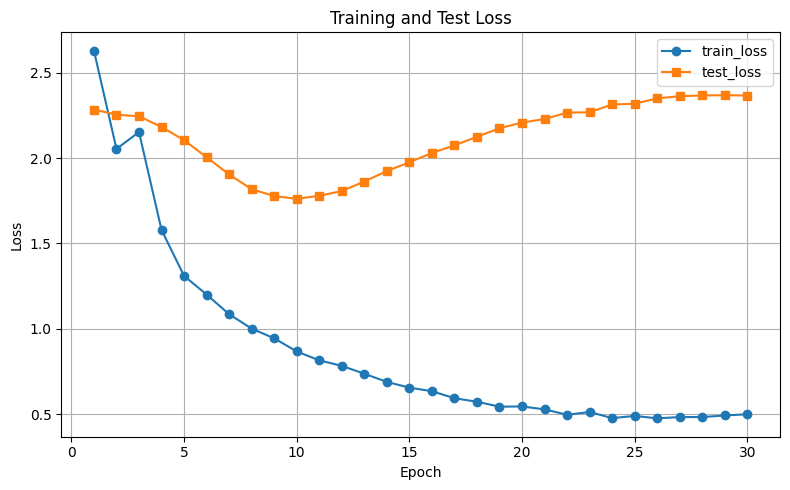



#### Treinando com 70 rótulos por classe e Tau=0.9 ####

Treinando do zero


  0%|          | 0/30 [00:00<?, ?it/s]

  Salvando melhor modelo - Acc=10.89% @ epoch 1
Ep 001 | L=3.238 (Ls=2.817, Lu=0.421, m=0.06) | Test Acc =10.89%


  3%|▎         | 1/30 [00:53<25:40, 53.11s/it]

Melhor acc: 10.89% @ epoch 1 | Final acc: 10.89%
Ep 002 | L=2.665 (Ls=2.217, Lu=0.447, m=0.07) | Test Acc =10.22%


  7%|▋         | 2/30 [01:45<24:35, 52.69s/it]

Melhor acc: 10.89% @ epoch 1 | Final acc: 10.89%
  Salvando melhor modelo - Acc=13.58% @ epoch 3
Ep 003 | L=2.765 (Ls=2.292, Lu=0.472, m=0.08) | Test Acc =13.58%


 10%|█         | 3/30 [02:38<23:42, 52.68s/it]

Melhor acc: 13.58% @ epoch 3 | Final acc: 13.58%
Ep 004 | L=2.472 (Ls=2.014, Lu=0.458, m=0.08) | Test Acc =11.70%


 13%|█▎        | 4/30 [03:29<22:34, 52.11s/it]

Melhor acc: 13.58% @ epoch 3 | Final acc: 13.58%
  Salvando melhor modelo - Acc=18.82% @ epoch 5
Ep 005 | L=2.300 (Ls=1.824, Lu=0.476, m=0.10) | Test Acc =18.82%


 17%|█▋        | 5/30 [04:20<21:32, 51.70s/it]

Melhor acc: 18.82% @ epoch 5 | Final acc: 18.82%
  Salvando melhor modelo - Acc=21.14% @ epoch 6
Ep 006 | L=1.998 (Ls=1.486, Lu=0.512, m=0.13) | Test Acc =21.14%


 20%|██        | 6/30 [05:11<20:35, 51.48s/it]

Melhor acc: 21.14% @ epoch 6 | Final acc: 21.14%
  Salvando melhor modelo - Acc=25.03% @ epoch 7
Ep 007 | L=1.838 (Ls=1.298, Lu=0.540, m=0.16) | Test Acc =25.03%


 23%|██▎       | 7/30 [06:02<19:43, 51.48s/it]

Melhor acc: 25.03% @ epoch 7 | Final acc: 25.03%
  Salvando melhor modelo - Acc=28.50% @ epoch 8
Ep 008 | L=1.725 (Ls=1.163, Lu=0.562, m=0.19) | Test Acc =28.50%


 27%|██▋       | 8/30 [06:53<18:46, 51.21s/it]

Melhor acc: 28.50% @ epoch 8 | Final acc: 28.50%
  Salvando melhor modelo - Acc=34.26% @ epoch 9
Ep 009 | L=1.542 (Ls=0.958, Lu=0.585, m=0.22) | Test Acc =34.26%


 30%|███       | 9/30 [07:44<17:52, 51.09s/it]

Melhor acc: 34.26% @ epoch 9 | Final acc: 34.26%
  Salvando melhor modelo - Acc=39.65% @ epoch 10
Ep 010 | L=1.391 (Ls=0.786, Lu=0.605, m=0.26) | Test Acc =39.65%


 33%|███▎      | 10/30 [08:36<17:06, 51.32s/it]

Melhor acc: 39.65% @ epoch 10 | Final acc: 39.65%
  Salvando melhor modelo - Acc=43.35% @ epoch 11
Ep 011 | L=1.326 (Ls=0.718, Lu=0.609, m=0.27) | Test Acc =43.35%


 37%|███▋      | 11/30 [09:27<16:17, 51.44s/it]

Melhor acc: 43.35% @ epoch 11 | Final acc: 43.35%
  Salvando melhor modelo - Acc=45.60% @ epoch 12
Ep 012 | L=1.194 (Ls=0.578, Lu=0.616, m=0.31) | Test Acc =45.60%


 40%|████      | 12/30 [10:18<15:23, 51.29s/it]

Melhor acc: 45.60% @ epoch 12 | Final acc: 45.60%
  Salvando melhor modelo - Acc=47.18% @ epoch 13
Ep 013 | L=1.119 (Ls=0.500, Lu=0.619, m=0.32) | Test Acc =47.18%


 43%|████▎     | 13/30 [11:10<14:33, 51.38s/it]

Melhor acc: 47.18% @ epoch 13 | Final acc: 47.18%
  Salvando melhor modelo - Acc=48.43% @ epoch 14
Ep 014 | L=1.041 (Ls=0.425, Lu=0.616, m=0.33) | Test Acc =48.43%


 47%|████▋     | 14/30 [12:01<13:38, 51.18s/it]

Melhor acc: 48.43% @ epoch 14 | Final acc: 48.43%
  Salvando melhor modelo - Acc=49.67% @ epoch 15
Ep 015 | L=0.962 (Ls=0.345, Lu=0.618, m=0.36) | Test Acc =49.67%


 50%|█████     | 15/30 [12:51<12:44, 51.00s/it]

Melhor acc: 49.67% @ epoch 15 | Final acc: 49.67%
  Salvando melhor modelo - Acc=50.52% @ epoch 16
Ep 016 | L=0.894 (Ls=0.289, Lu=0.605, m=0.37) | Test Acc =50.52%


 53%|█████▎    | 16/30 [13:42<11:52, 50.90s/it]

Melhor acc: 50.52% @ epoch 16 | Final acc: 50.52%
  Salvando melhor modelo - Acc=51.34% @ epoch 17
Ep 017 | L=0.801 (Ls=0.216, Lu=0.585, m=0.39) | Test Acc =51.34%


 57%|█████▋    | 17/30 [14:33<11:01, 50.90s/it]

Melhor acc: 51.34% @ epoch 17 | Final acc: 51.34%
  Salvando melhor modelo - Acc=51.74% @ epoch 18
Ep 018 | L=0.757 (Ls=0.186, Lu=0.570, m=0.39) | Test Acc =51.74%


 60%|██████    | 18/30 [15:24<10:11, 50.96s/it]

Melhor acc: 51.74% @ epoch 18 | Final acc: 51.74%
  Salvando melhor modelo - Acc=52.41% @ epoch 19
Ep 019 | L=0.705 (Ls=0.146, Lu=0.559, m=0.41) | Test Acc =52.41%


 63%|██████▎   | 19/30 [16:15<09:19, 50.88s/it]

Melhor acc: 52.41% @ epoch 19 | Final acc: 52.41%
  Salvando melhor modelo - Acc=52.76% @ epoch 20
Ep 020 | L=0.654 (Ls=0.116, Lu=0.538, m=0.42) | Test Acc =52.76%


 67%|██████▋   | 20/30 [17:06<08:29, 50.90s/it]

Melhor acc: 52.76% @ epoch 20 | Final acc: 52.76%
  Salvando melhor modelo - Acc=52.92% @ epoch 21
Ep 021 | L=0.627 (Ls=0.089, Lu=0.538, m=0.44) | Test Acc =52.92%


 70%|███████   | 21/30 [17:56<07:38, 50.89s/it]

Melhor acc: 52.92% @ epoch 21 | Final acc: 52.92%
  Salvando melhor modelo - Acc=53.25% @ epoch 22
Ep 022 | L=0.592 (Ls=0.066, Lu=0.526, m=0.45) | Test Acc =53.25%


 73%|███████▎  | 22/30 [18:48<06:47, 50.97s/it]

Melhor acc: 53.25% @ epoch 22 | Final acc: 53.25%
  Salvando melhor modelo - Acc=53.60% @ epoch 23
Ep 023 | L=0.558 (Ls=0.044, Lu=0.514, m=0.45) | Test Acc =53.60%


 77%|███████▋  | 23/30 [19:39<05:57, 51.13s/it]

Melhor acc: 53.60% @ epoch 23 | Final acc: 53.60%
Ep 024 | L=0.534 (Ls=0.035, Lu=0.499, m=0.45) | Test Acc =53.46%


 80%|████████  | 24/30 [20:30<05:06, 51.03s/it]

Melhor acc: 53.60% @ epoch 23 | Final acc: 53.60%
  Salvando checkpoint de treinamento @ epoch 25
Ep 025 | L=0.528 (Ls=0.029, Lu=0.499, m=0.46) | Test Acc =53.53%


 83%|████████▎ | 25/30 [21:21<04:14, 50.97s/it]

Melhor acc: 53.60% @ epoch 23 | Final acc: 53.60%
  Salvando melhor modelo - Acc=53.62% @ epoch 26
Ep 026 | L=0.531 (Ls=0.025, Lu=0.507, m=0.46) | Test Acc =53.62%


 87%|████████▋ | 26/30 [22:11<03:23, 50.91s/it]

Melhor acc: 53.62% @ epoch 26 | Final acc: 53.62%
  Salvando melhor modelo - Acc=53.69% @ epoch 27
Ep 027 | L=0.528 (Ls=0.020, Lu=0.508, m=0.46) | Test Acc =53.69%


 90%|█████████ | 27/30 [23:02<02:32, 50.91s/it]

Melhor acc: 53.69% @ epoch 27 | Final acc: 53.69%
  Salvando melhor modelo - Acc=53.85% @ epoch 28
Ep 028 | L=0.516 (Ls=0.017, Lu=0.499, m=0.45) | Test Acc =53.85%


 93%|█████████▎| 28/30 [23:56<01:43, 51.73s/it]

Melhor acc: 53.85% @ epoch 28 | Final acc: 53.85%
Ep 029 | L=0.520 (Ls=0.016, Lu=0.504, m=0.45) | Test Acc =53.80%


 97%|█████████▋| 29/30 [24:48<00:51, 51.94s/it]

Melhor acc: 53.85% @ epoch 28 | Final acc: 53.85%
  Salvando checkpoint de treinamento @ epoch 30
Ep 030 | L=0.516 (Ls=0.016, Lu=0.500, m=0.45) | Test Acc =53.71%


100%|██████████| 30/30 [25:40<00:00, 51.36s/it]

Melhor acc: 53.85% @ epoch 28 | Final acc: 53.85%


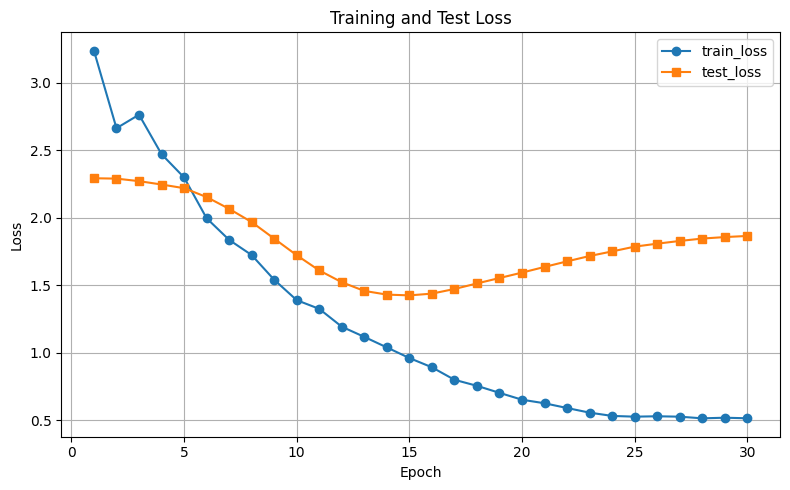



#### Treinando com 400 rótulos por classe e Tau=0.9 ####

Treinando do zero


  0%|          | 0/30 [00:00<?, ?it/s]

  Salvando melhor modelo - Acc=13.02% @ epoch 1
Ep 001 | L=3.444 (Ls=2.951, Lu=0.494, m=0.04) | Test Acc =13.02%


  3%|▎         | 1/30 [00:50<24:17, 50.24s/it]

Melhor acc: 13.02% @ epoch 1 | Final acc: 13.02%
  Salvando melhor modelo - Acc=15.45% @ epoch 2
Ep 002 | L=3.713 (Ls=3.208, Lu=0.506, m=0.05) | Test Acc =15.45%


  7%|▋         | 2/30 [01:39<23:06, 49.52s/it]

Melhor acc: 15.45% @ epoch 2 | Final acc: 15.45%
Ep 003 | L=2.706 (Ls=2.319, Lu=0.388, m=0.05) | Test Acc =13.82%


 10%|█         | 3/30 [02:27<22:07, 49.16s/it]

Melhor acc: 15.45% @ epoch 2 | Final acc: 15.45%
Ep 004 | L=2.638 (Ls=2.288, Lu=0.349, m=0.06) | Test Acc =12.81%


 13%|█▎        | 4/30 [03:17<21:19, 49.20s/it]

Melhor acc: 15.45% @ epoch 2 | Final acc: 15.45%
  Salvando checkpoint de treinamento @ epoch 5
Ep 005 | L=2.930 (Ls=2.460, Lu=0.470, m=0.05) | Test Acc =12.07%


 17%|█▋        | 5/30 [04:06<20:30, 49.22s/it]

Melhor acc: 15.45% @ epoch 2 | Final acc: 15.45%
Ep 006 | L=2.993 (Ls=2.614, Lu=0.379, m=0.05) | Test Acc =10.93%


 20%|██        | 6/30 [04:55<19:39, 49.15s/it]

Melhor acc: 15.45% @ epoch 2 | Final acc: 15.45%
Ep 007 | L=2.758 (Ls=2.355, Lu=0.403, m=0.04) | Test Acc =10.56%


 23%|██▎       | 7/30 [05:44<18:52, 49.25s/it]

Melhor acc: 15.45% @ epoch 2 | Final acc: 15.45%
  Salvando melhor modelo - Acc=15.51% @ epoch 8
Ep 008 | L=2.708 (Ls=2.308, Lu=0.401, m=0.04) | Test Acc =15.51%


 27%|██▋       | 8/30 [06:34<18:06, 49.39s/it]

Melhor acc: 15.51% @ epoch 8 | Final acc: 15.51%
Ep 009 | L=2.330 (Ls=1.965, Lu=0.365, m=0.06) | Test Acc =14.97%


 30%|███       | 9/30 [07:24<17:19, 49.50s/it]

Melhor acc: 15.51% @ epoch 8 | Final acc: 15.51%
  Salvando melhor modelo - Acc=15.52% @ epoch 10
Ep 010 | L=2.197 (Ls=1.938, Lu=0.258, m=0.06) | Test Acc =15.52%


 33%|███▎      | 10/30 [08:14<16:32, 49.61s/it]

Melhor acc: 15.52% @ epoch 10 | Final acc: 15.52%
  Salvando melhor modelo - Acc=18.09% @ epoch 11
Ep 011 | L=2.121 (Ls=1.793, Lu=0.328, m=0.08) | Test Acc =18.09%


 37%|███▋      | 11/30 [09:02<15:35, 49.26s/it]

Melhor acc: 18.09% @ epoch 11 | Final acc: 18.09%
  Salvando melhor modelo - Acc=21.60% @ epoch 12
Ep 012 | L=2.123 (Ls=1.781, Lu=0.341, m=0.07) | Test Acc =21.60%


 40%|████      | 12/30 [09:51<14:43, 49.06s/it]

Melhor acc: 21.60% @ epoch 12 | Final acc: 21.60%
  Salvando melhor modelo - Acc=26.75% @ epoch 13
Ep 013 | L=2.123 (Ls=1.737, Lu=0.386, m=0.08) | Test Acc =26.75%


 43%|████▎     | 13/30 [10:40<13:53, 49.01s/it]

Melhor acc: 26.75% @ epoch 13 | Final acc: 26.75%
  Salvando melhor modelo - Acc=31.55% @ epoch 14
Ep 014 | L=1.933 (Ls=1.609, Lu=0.324, m=0.10) | Test Acc =31.55%


 47%|████▋     | 14/30 [11:29<13:03, 48.98s/it]

Melhor acc: 31.55% @ epoch 14 | Final acc: 31.55%
  Salvando melhor modelo - Acc=36.88% @ epoch 15
Ep 015 | L=1.899 (Ls=1.549, Lu=0.350, m=0.11) | Test Acc =36.88%


 50%|█████     | 15/30 [12:17<12:12, 48.86s/it]

Melhor acc: 36.88% @ epoch 15 | Final acc: 36.88%
  Salvando melhor modelo - Acc=41.69% @ epoch 16
Ep 016 | L=1.789 (Ls=1.445, Lu=0.344, m=0.14) | Test Acc =41.69%


 53%|█████▎    | 16/30 [13:06<11:23, 48.80s/it]

Melhor acc: 41.69% @ epoch 16 | Final acc: 41.69%
  Salvando melhor modelo - Acc=45.64% @ epoch 17
Ep 017 | L=1.712 (Ls=1.362, Lu=0.350, m=0.15) | Test Acc =45.64%


 57%|█████▋    | 17/30 [13:55<10:33, 48.76s/it]

Melhor acc: 45.64% @ epoch 17 | Final acc: 45.64%
  Salvando melhor modelo - Acc=48.89% @ epoch 18
Ep 018 | L=1.650 (Ls=1.311, Lu=0.340, m=0.17) | Test Acc =48.89%


 60%|██████    | 18/30 [14:43<09:45, 48.75s/it]

Melhor acc: 48.89% @ epoch 18 | Final acc: 48.89%
  Salvando melhor modelo - Acc=51.06% @ epoch 19
Ep 019 | L=1.621 (Ls=1.279, Lu=0.343, m=0.18) | Test Acc =51.06%


 63%|██████▎   | 19/30 [15:32<08:57, 48.82s/it]

Melhor acc: 51.06% @ epoch 19 | Final acc: 51.06%
  Salvando melhor modelo - Acc=53.17% @ epoch 20
Ep 020 | L=1.513 (Ls=1.166, Lu=0.346, m=0.20) | Test Acc =53.17%


 67%|██████▋   | 20/30 [16:22<08:11, 49.14s/it]

Melhor acc: 53.17% @ epoch 20 | Final acc: 53.17%
  Salvando melhor modelo - Acc=54.50% @ epoch 21
Ep 021 | L=1.487 (Ls=1.130, Lu=0.357, m=0.21) | Test Acc =54.50%


 70%|███████   | 21/30 [17:12<07:24, 49.41s/it]

Melhor acc: 54.50% @ epoch 21 | Final acc: 54.50%
  Salvando melhor modelo - Acc=56.09% @ epoch 22
Ep 022 | L=1.439 (Ls=1.089, Lu=0.350, m=0.22) | Test Acc =56.09%


 73%|███████▎  | 22/30 [18:02<06:37, 49.63s/it]

Melhor acc: 56.09% @ epoch 22 | Final acc: 56.09%
  Salvando melhor modelo - Acc=57.00% @ epoch 23
Ep 023 | L=1.359 (Ls=1.011, Lu=0.349, m=0.24) | Test Acc =57.00%


 77%|███████▋  | 23/30 [18:51<05:45, 49.36s/it]

Melhor acc: 57.00% @ epoch 23 | Final acc: 57.00%
  Salvando melhor modelo - Acc=57.95% @ epoch 24
Ep 024 | L=1.308 (Ls=0.962, Lu=0.346, m=0.25) | Test Acc =57.95%


 80%|████████  | 24/30 [19:40<04:54, 49.14s/it]

Melhor acc: 57.95% @ epoch 24 | Final acc: 57.95%
  Salvando melhor modelo - Acc=58.34% @ epoch 25
Ep 025 | L=1.262 (Ls=0.905, Lu=0.358, m=0.26) | Test Acc =58.34%


 83%|████████▎ | 25/30 [20:27<04:03, 48.67s/it]

Melhor acc: 58.34% @ epoch 25 | Final acc: 58.34%
  Salvando melhor modelo - Acc=59.01% @ epoch 26
Ep 026 | L=1.233 (Ls=0.880, Lu=0.352, m=0.26) | Test Acc =59.01%


 87%|████████▋ | 26/30 [21:16<03:14, 48.73s/it]

Melhor acc: 59.01% @ epoch 26 | Final acc: 59.01%
  Salvando melhor modelo - Acc=59.28% @ epoch 27
Ep 027 | L=1.206 (Ls=0.857, Lu=0.348, m=0.27) | Test Acc =59.28%


 90%|█████████ | 27/30 [22:05<02:26, 48.88s/it]

Melhor acc: 59.28% @ epoch 27 | Final acc: 59.28%
  Salvando melhor modelo - Acc=59.31% @ epoch 28
Ep 028 | L=1.153 (Ls=0.819, Lu=0.335, m=0.28) | Test Acc =59.31%


 93%|█████████▎| 28/30 [22:54<01:37, 48.85s/it]

Melhor acc: 59.31% @ epoch 28 | Final acc: 59.31%
  Salvando melhor modelo - Acc=59.42% @ epoch 29
Ep 029 | L=1.174 (Ls=0.846, Lu=0.328, m=0.27) | Test Acc =59.42%


 97%|█████████▋| 29/30 [23:43<00:48, 48.80s/it]

Melhor acc: 59.42% @ epoch 29 | Final acc: 59.42%
  Salvando melhor modelo - Acc=59.45% @ epoch 30
Ep 030 | L=1.164 (Ls=0.841, Lu=0.323, m=0.27) | Test Acc =59.45%


100%|██████████| 30/30 [24:32<00:00, 49.07s/it]

Melhor acc: 59.45% @ epoch 30 | Final acc: 59.45%


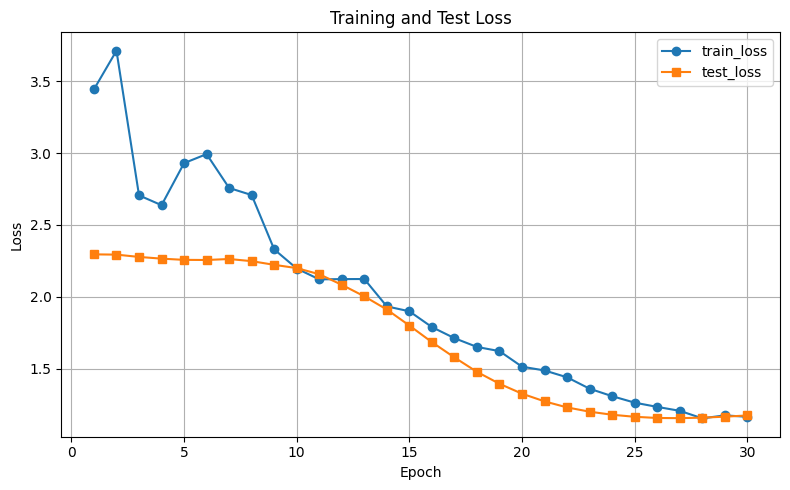

In [26]:
import itertools
EPOCHS = 30
taus = [0.9]
qnt_labels = [1, 4, 25, 70, 400]

for tau, labels_per_class in itertools.product(taus, qnt_labels):
    print(f"\n\n#### Treinando com {labels_per_class} rótulos por classe e Tau={tau} ####\n")
    
    create_and_train_model(epochs=EPOCHS, labels_per_class=labels_per_class, tau=tau)